In [6]:
# WHAT: imports and global config
# WHY : establish reproducible, consistent environment for classification

import os, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, classification_report,
    confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

## 1. Load & Inspect
**Goal:** Load the churn dataset and validate the data contract (columns, types, NA).

In [7]:
# WHAT: read CSV and basic checks
# WHY : ensure expected schema exists before modeling

df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())
print(df.shape)
print(df.isna().sum().sort_values(ascending=False).head())

TARGET = "churn"        # 0/1
ID_COL = "customer_id"  # optional if available
# Optional time column if you want time-based split later:
# TIME_COL = "signup_date"  # or "last_activity"

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

## 2. Quick EDA
**Goal:** Understand class imbalance and basic distribution quirks.

✅ Target column detected → churn
📊 Churn rate: 26.54%


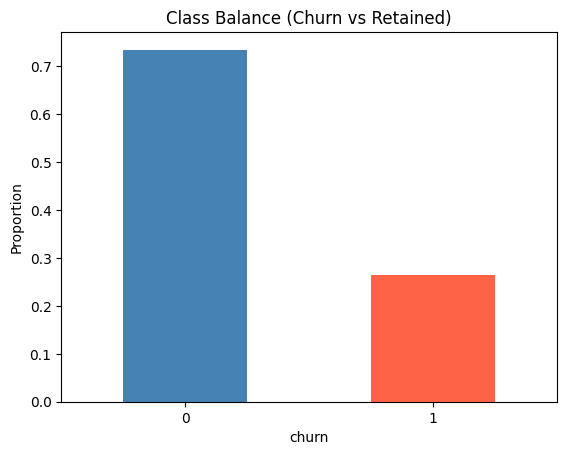

🩹 Columns with missing values:


totalcharges    11
dtype: int64

In [15]:
# ── 2. EDA: Quick Overview ───────────────────────────────────────────
# WHAT: standardize dataset, detect target column, check balance & missingness
# WHY : ensure label consistency, prevent leakage, and prep for preprocessing


# 2.1 Normalize column names
# WHAT : unify column naming to lower_case_with_underscores
# WHY  : avoid mismatched keys like "Churn" vs "churn"
orig_cols = df.columns.tolist()
df.columns = (
    df.columns
      .str.strip()
      .str.replace(r"\s+", "_", regex=True)
      .str.lower()
)


# 2.2 Detect target column (churn)
# WHAT : automatically find likely churn column (churn / is_churn / churn_flag)
# WHY  : makes notebook reusable across datasets
cand = [c for c in df.columns if c in ["churn", "is_churn", "churn_flag"] or c.endswith("_churn")]
if not cand:
    raise ValueError(f"No churn-like column found. Available columns: {list(df.columns)[:10]} ...")
TARGET = cand[0]
print(f"✅ Target column detected → {TARGET}")


# 2.3 Map target to numeric
# WHAT : convert Yes/No or True/False labels to 1/0 integers
# WHY  : unify label type for ML classifiers
if df[TARGET].dtype == "object":
    mapping = {"yes": 1, "no": 0, "true": 1, "false": 0, "1": 1, "0": 0}
    df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().map(mapping)
    if df[TARGET].isna().any():
        print("⚠️ Unmapped target values:", df[TARGET].unique())
        raise ValueError("Please extend mapping for target values.")
df[TARGET] = df[TARGET].astype(int)


# 2.4 Fix numeric-type issues (Telco-specific)
# WHAT : convert totalcharges to numeric; blank entries → NaN
# WHY  : common Kaggle Telco issue
if "totalcharges" in df.columns and df["totalcharges"].dtype == "object":
    df["totalcharges"] = pd.to_numeric(df["totalcharges"].str.strip().replace("", np.nan), errors="coerce")


# 2.5 Churn class balance visualization
# WHAT : visualize churn vs retained proportions
# WHY  : check imbalance severity (affects metrics & resampling)
churn_rate = df[TARGET].mean()
print(f"📊 Churn rate: {churn_rate:.2%}")
df[TARGET].value_counts(normalize=True).plot(kind="bar", color=["steelblue","tomato"])
plt.title("Class Balance (Churn vs Retained)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()


# 2.6 Missing value overview
# WHAT : inspect top columns with missing data
# WHY  : define imputation strategy before modeling
na_cnt = df.isna().sum().sort_values(ascending=False)
if na_cnt.max() > 0:
    print("🩹 Columns with missing values:")
    display(na_cnt[na_cnt > 0].head(15))
else:
    print("✅ No missing values detected.")

## 3. Anti-Leakage Declaration
**Goal:** Make leakage guardrails explicit before feature engineering and split.

In [11]:
print("""
Anti-leakage policy:
- No features derived from post-churn period (no lookahead).
- Preprocessing/selection fit on TRAIN only.
- Split is stratified by label (or time-based if cohort effect exists).
""")


Anti-leakage policy:
- No features derived from post-churn period (no lookahead).
- Preprocessing/selection fit on TRAIN only.
- Split is stratified by label (or time-based if cohort effect exists).



## 4. Train / Validation Split
**Goal:** Create a stratified split (or switch to time-based if needed).

In [12]:
# WHAT: create train/valid sets with stratification
# WHY : preserve label distribution; avoid optimistic bias

X = df.drop(columns=[TARGET])          # keep ID_COL if you need it later
y = df[TARGET].astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train/Valid:", X_train.shape, X_valid.shape)

Train/Valid: (5634, 20) (1409, 20)


## 5. Baseline Models: LogReg / RF / XGB
**Goal:** Establish solid baselines with unified preprocessing via sklearn Pipeline.

In [18]:
# ── 6. Baseline models with robust preprocessing ─────────────────────
# WHAT: preprocessing + candidate models (with imputation)
# WHY : avoid NaN errors, unify numeric/categorical handling, benchmark learners
# HOW : ColumnTransformer(num_pipe, cat_pipe) → Pipeline(prep → clf)

from sklearn.impute import SimpleImputer

# 6.1 Build numeric / categorical pipelines
# - Numeric: median imputation → scaling
# - Categorical: most_frequent imputation → OneHot
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler(with_mean=False))
])

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe",    OneHotEncoder(handle_unknown="ignore"))
])

# 防御：若某一类列为空，ColumnTransformer 仍然能工作
transformers = []
if len(num_cols) > 0:
    transformers.append(("num", num_pipe, num_cols))
if len(cat_cols) > 0:
    transformers.append(("cat", cat_pipe, cat_cols))

preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.3  # encourage sparse output after OHE
)

# 6.2 Class imbalance hint for XGB: neg/pos ratio (可选)
pos = int(y_train.sum())
neg = int((y_train == 0).sum())
scale_pos_weight = None
if pos > 0:
    scale_pos_weight = neg / pos  # heuristic for imbalanced data

# 6.3 Candidate models
candidates = {
    "logreg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "rf": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE
    ),
    "xgb": XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        reg_alpha=0.0,
        reg_lambda=1.0,
        scale_pos_weight=scale_pos_weight  # ← imbalance-aware
    )
}

def eval_model(name, clf):
    # HOW : Pipeline = preprocess → classifier; evaluate on valid
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)

    # 兼容：若无 predict_proba（这里都有），可 fallback 到 decision_function
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba = pipe.predict_proba(X_valid)[:, 1]
    else:
        # fallback（一般用不上）
        scores = pipe.decision_function(X_valid)
        # 简单映射为 [0,1] 概率（仅作占位）
        proba = 1 / (1 + np.exp(-scores))

    preds = (proba >= 0.5).astype(int)
    auc  = roc_auc_score(y_valid, proba)
    pr   = average_precision_score(y_valid, proba)
    f1   = f1_score(y_valid, preds)
    print(f"[{name}] AUC={auc:.3f} | PR-AUC={pr:.3f} | F1@0.5={f1:.3f}")
    return pipe, proba

# 6.4 Fit all candidates and store artifacts
fitted = {}
for k, m in candidates.items():
    pipe, proba = eval_model(k, m)
    fitted[k] = {"pipe": pipe, "proba": proba}

[logreg] AUC=0.841 | PR-AUC=0.632 | F1@0.5=0.621
[rf] AUC=0.827 | PR-AUC=0.618 | F1@0.5=0.560
[xgb] AUC=0.837 | PR-AUC=0.648 | F1@0.5=0.622


## 6. Threshold Search
**Goal:** Find a business-aligned threshold (e.g., maximize F1 or recall@precision).

In [19]:
# WHAT: sweep thresholds on the chosen model (e.g., XGB) to optimize an objective
# WHY : 0.5 rarely optimal under class imbalance and asymmetric costs

best_t, best_f1 = 0.5, -1
for t in np.linspace(0.1, 0.9, 17):
    preds = (fitted["xgb"]["proba"] >= t).astype(int)
    f1 = f1_score(y_valid, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best threshold by F1: t={best_t:.2f}, F1={best_f1:.3f}")

Best threshold by F1: t=0.45, F1=0.623


## 7. Report @ Best Threshold
**Goal:** Show classification report and confusion matrix at selected threshold.

              precision    recall  f1-score   support

           0      0.908     0.726     0.807      1035
           1      0.512     0.797     0.623       374

    accuracy                          0.744      1409
   macro avg      0.710     0.761     0.715      1409
weighted avg      0.803     0.744     0.758      1409



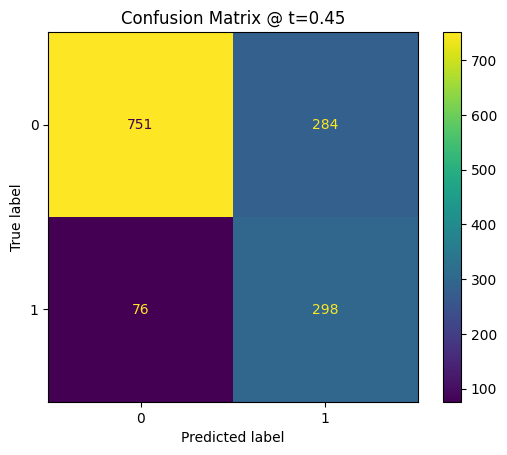

Precision=0.512 | Recall=0.797 @ t=0.45


In [20]:
# WHAT: generate confusion matrix and per-class metrics at chosen threshold
# WHY : ensure operating point is understood by stakeholders

from sklearn.metrics import ConfusionMatrixDisplay

proba_best = fitted["xgb"]["proba"]
preds_best = (proba_best >= best_t).astype(int)

print(classification_report(y_valid, preds_best, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_valid, preds_best)).plot()
plt.title(f"Confusion Matrix @ t={best_t:.2f}"); plt.show()

prec = precision_score(y_valid, preds_best)
rec  = recall_score(y_valid, preds_best)
print(f"Precision={prec:.3f} | Recall={rec:.3f} @ t={best_t:.2f}")

## 8. Error Slicing
**Goal:** Diagnose where the model underperforms (by segments).

In [22]:
# WHAT: slice errors by business-meaningful segments (e.g., tenure buckets)
# WHY : inform actions (e.g., targeted offers on weak segments)

seg_col = "tenure_months" if "tenure_months" in X_valid.columns else None
if seg_col:
    tmp = X_valid.copy()
    tmp["y"] = y_valid.values
    tmp["proba"] = proba_best
    tmp["pred"]  = preds_best
    tmp["abs_err"] = (tmp["y"] - tmp["proba"]).abs()
    tmp["tenure_bin"] = pd.qcut(tmp[seg_col], q=5, duplicates="drop")
    print(tmp.groupby("tenure_bin")["abs_err"].mean())

## 9. Explainability (SHAP)
**Goal:** Provide global feature importance (and optionally local cases).

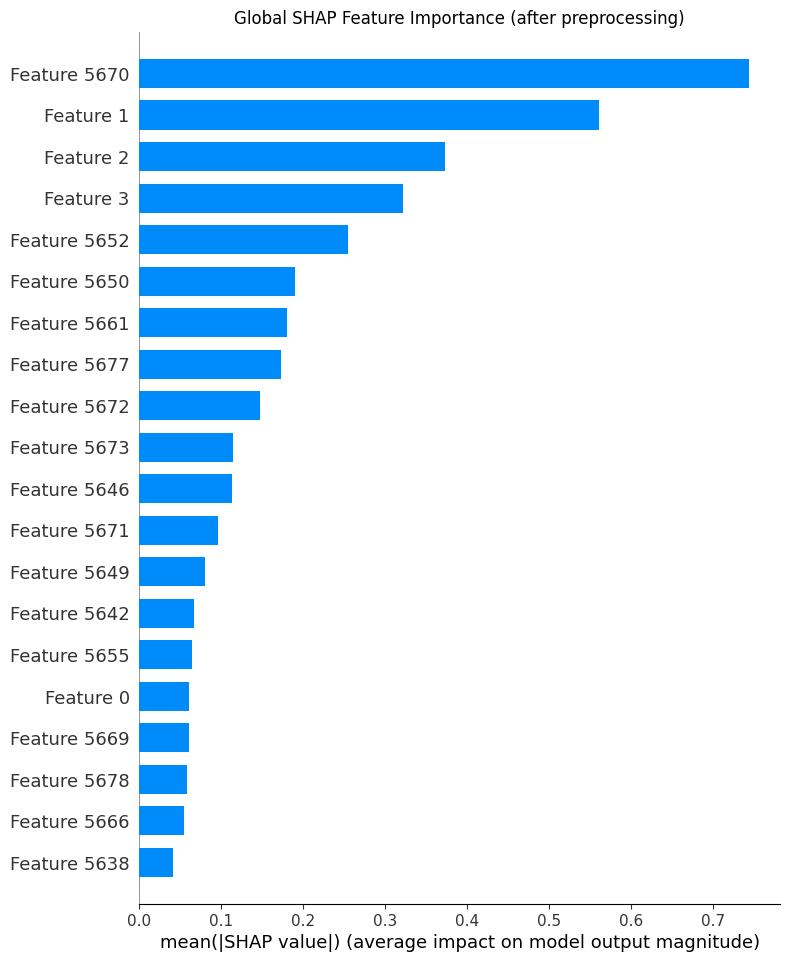

In [23]:
# WHAT: SHAP on the fitted XGB (after preprocessing)
# WHY : communicate key drivers and ensure model transparency

xgb_pipe = fitted["xgb"]["pipe"]
X_train_t = xgb_pipe.named_steps["prep"].fit_transform(X_train)
model     = xgb_pipe.named_steps["clf"]

explainer = shap.TreeExplainer(model)
bg_idx    = np.random.choice(X_train_t.shape[0], size=min(1000, X_train_t.shape[0]), replace=False)
shap_values = explainer.shap_values(X_train_t[bg_idx])

shap.summary_plot(shap_values, X_train_t[bg_idx], show=False, plot_type="bar")
plt.title("Global SHAP Feature Importance (after preprocessing)"); plt.show()

## 10. (Optional) Cross-Validation
**Goal:** Validate robustness via stratified K-fold (scores = mean ± std).

In [24]:
# TODO (optional): add StratifiedKFold to estimate robustness
# WHY : ensure stable performance across folds under class imbalance

## 11. Business Translation
**Goal:** Translate model metrics into ops terms (retention campaign targeting).

In [25]:
# WHAT: connect precision/recall at chosen threshold to campaign ROI
# WHY : stakeholders think in costs and returns, not only AUC

# --- Toy assumptions (replace with your business numbers) ---
contact_cost = 5.0          # DKK per contacted customer (SMS/call/offer cost)
retention_value = 300.0     # DKK saved if a churning customer is retained
base_rate = y_valid.mean()  # observed churn rate in validation

# --- Estimated outcomes at this threshold ---
TP = ((y_valid == 1) & (preds_best == 1)).sum()
FP = ((y_valid == 0) & (preds_best == 1)).sum()
FN = ((y_valid == 1) & (preds_best == 0)).sum()
TN = ((y_valid == 0) & (preds_best == 0)).sum()

contacted = (preds_best == 1).sum()
# conservative assumption: retention succeeds for a fraction of true churners you contact
assumed_success_rate = 0.25  # TODO: align with CRM team / historical uplift
expected_saves = TP * assumed_success_rate

gross_benefit = expected_saves * retention_value
campaign_cost = contacted * contact_cost
net_gain = gross_benefit - campaign_cost

print(f"Contacts={contacted} | TP={TP} | FP={FP} | FN={FN} | TN={TN}")
print(f"Assumed save rate among TP: {assumed_success_rate:.0%}")
print(f"Gross benefit ≈ {gross_benefit:,.0f} DKK | Cost ≈ {campaign_cost:,.0f} DKK | Net ≈ {net_gain:,.0f} DKK")
print("Note: Replace assumptions with real unit economics; choose threshold to maximize net.")

Contacts=582 | TP=298 | FP=284 | FN=76 | TN=751
Assumed save rate among TP: 25%
Gross benefit ≈ 22,350 DKK | Cost ≈ 2,910 DKK | Net ≈ 19,440 DKK
Note: Replace assumptions with real unit economics; choose threshold to maximize net.


## 12. Save Artifacts & Reproducibility
**Goal:** Persist metrics and config; prepare for later CLI/pipeline refactor.

In [27]:
# WHAT: save key metrics and chosen threshold for reproducibility
# WHY : enable reporting, comparisons, and pipeline automation

os.makedirs("../reports", exist_ok=True)

auc  = roc_auc_score(y_valid, proba_best)
pr   = average_precision_score(y_valid, proba_best)
f1   = f1_score(y_valid, preds_best)
prec = precision_score(y_valid, preds_best)
rec  = recall_score(y_valid, preds_best)

artifacts = {
    "best_model": "xgb",
    "best_threshold": float(best_t),
    "metrics_valid": {
        "roc_auc": float(auc),
        "pr_auc": float(pr),
        "f1": float(f1),
        "precision_at_t": float(prec),
        "recall_at_t": float(rec)
    },
    "confusion_matrix": {
        "TP": int(((y_valid == 1) & (preds_best == 1)).sum()),
        "FP": int(((y_valid == 0) & (preds_best == 1)).sum()),
        "FN": int(((y_valid == 1) & (preds_best == 0)).sum()),
        "TN": int(((y_valid == 0) & (preds_best == 0)).sum())
    },
    "random_state": RANDOM_STATE
}
json.dump(artifacts, open("../reports/churn_metrics.json","w"), indent=2)
print("✅ Saved → ../reports/churn_metrics.json")

print("""
Reproducibility hook (placeholder):
You can later refactor this notebook into CLI:
  python -m src.train_churn --config configs/churn_base.yaml
""")

✅ Saved → ../reports/churn_metrics.json

Reproducibility hook (placeholder):
You can later refactor this notebook into CLI:
  python -m src.train_churn --config configs/churn_base.yaml

